# Face landmark

https://developers.google.com/mediapipe/solutions/vision/face_landmarker

In [1]:
# !wget -O ./models/face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [4]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [7]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [5]:
model_path = './models/face_landmarker_v2_with_blendshapes.task'

In [3]:
def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

## Image

In [9]:
base_options = python.BaseOptions(model_asset_path=model_path)
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                        output_face_blendshapes=True,
                                        output_facial_transformation_matrixes=True,
                                        num_faces=1)

image = mp.Image.create_from_file("./../../../../test_img/woman.jpg")

In [11]:
with vision.FaceLandmarker.create_from_options(options) as detector:
    detection_result = detector.detect(image)
    
    annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
    cv2.imshow('test', cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
    cv2.waitKey(3000)
    cv2.destroyAllWindows()

W20240410 19:28:17.471633 3796753472 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.


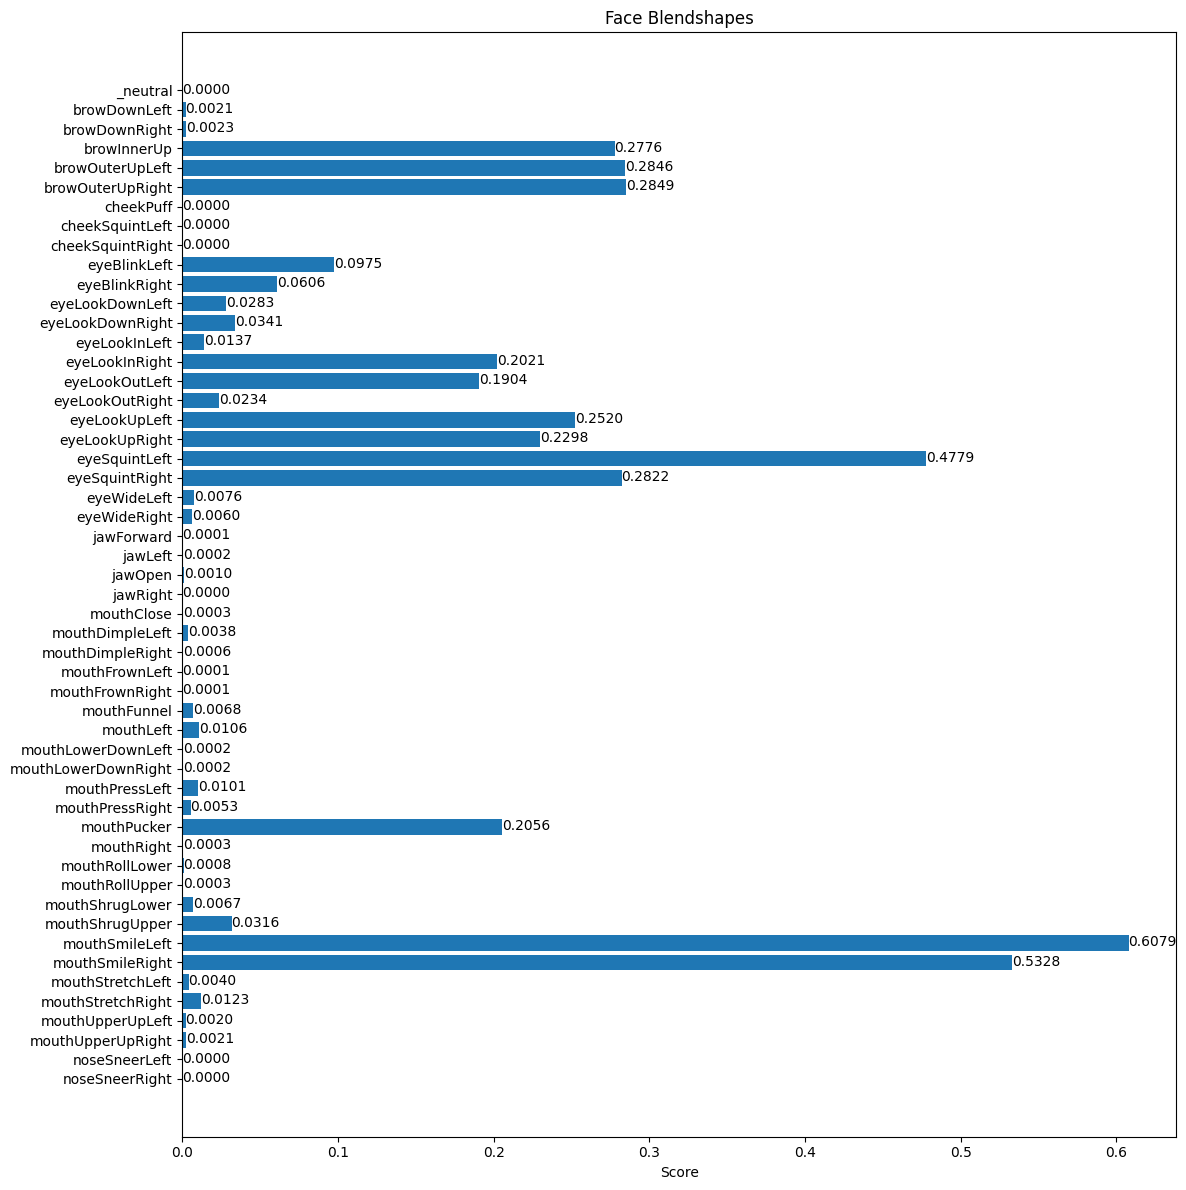

In [16]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

In [15]:
detection_result.facial_transformation_matrixes

[array([[ 9.98439252e-01,  1.05989091e-02, -5.48359416e-02,
         -1.10720122e+00],
        [-2.23827735e-02,  9.75468636e-01, -2.18998179e-01,
          4.49096298e+00],
        [ 5.11695854e-02,  2.19883561e-01,  9.74183500e-01,
         -3.64047394e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])]

## Video

In [ ]:
cap = cv2.VideoCapture('./../../../../test_video/face_1.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
output_vid = cv2.VideoWriter('./../segmentation_output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

In [18]:
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode
options = FaceLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.VIDEO)

In [31]:
with FaceLandmarker.create_from_options(options) as landmarker:
    frame_index = 1
    while True:
        ret, frame = cap.read()
        if ret:
            numpy_frame_from_opencv = np.asarray(frame)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=numpy_frame_from_opencv)
            frame_timestamp_ms = int(1000 * frame_index / fps)
            face_landmarker_result = landmarker.detect_for_video(mp_image, frame_timestamp_ms)

            annotated_image = draw_landmarks_on_image(numpy_frame_from_opencv, face_landmarker_result)
            # 書き込み
            output_vid.write(annotated_image)
            
            frame_index += 1
        else:
            # VideoWriterを解放
            output_vid.release()
            cap.release()
            break

W20240410 20:15:39.741776 3796753472 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.


## Camera

In [32]:
base_options = python.BaseOptions(model_asset_path=model_path)
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                        output_face_blendshapes=True,
                                        output_facial_transformation_matrixes=True,
                                        num_faces=1)

In [37]:
with vision.FaceLandmarker.create_from_options(options) as detector:
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if ret:
            numpy_frame_from_opencv = np.asarray(frame)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=numpy_frame_from_opencv)
            detection_result = detector.detect(mp_image)
            
            if 0 < len(detection_result.face_landmarks):
                annotated_image = draw_landmarks_on_image(numpy_frame_from_opencv, detection_result)
                cv2.imshow('camera', annotated_image)
            else:
                cv2.imshow('camera', frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()

W20240410 20:33:37.590605 3796753472 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.
